# QuantumMusic - Unified Version with Larger LUFS Chunk

### Introduction
This notebook merges:
- **Module 7: Dynamics (RMS + LUFS)** with a **longer** chunk size for loudness calculations.
- **Multi‐chunk tempo** (512, 4096, 16384).

We do **not** remove any docstrings or modules. We have introduced a new constant `LUFS_CHUNK_SIZE` in **Module 7**. **Additionally**, we have added short‐chunk fixes (`n_fft_local = min(...)`) so Librosa won't emit warnings about chunk length < `n_fft`.

Author: Rohan Agarwal

## 1. Constants & Imports

In [39]:
# 1. CONSTANTS & IMPORTS

import os
import sys
import psycopg2
from psycopg2.extras import Json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# For Praat-based HNR
import parselmouth
from parselmouth.praat import call

# For audio playback in Jupyter
from IPython.display import Audio, display

# For LUFS-based loudness
try:
    import pyloudnorm as pyln
    LOUDNORM_AVAILABLE = True
except ImportError:
    LOUDNORM_AVAILABLE = False
    print("Warning: pyloudnorm not installed, LUFS computations will be skipped.")

# Quantum Computing imports
# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # modern Aer simulator from qiskit-aer


# Directory constants
INPUT_DIR = "input"
OUTPUT_DIR = "output"

# Database constants
DB_NAME = "quantummusic"
DB_HOST = "localhost"
DB_USER = "postgres"  # placeholder
DB_PASSWORD = "postgres"  # placeholder

# Audio processing constants
STANDARD_SR = 44100  # Standard sampling rate
SILENCE_THRESHOLD_DB = 30  # dB threshold for silence trimming

# Band-pass filter constants
LOW_FREQ = 80.0
HIGH_FREQ = 3000.0

# Visualization constants
FIG_SIZE = (10, 4)

# Save-to-DB constant
SAVE_TO_DB = True

# Frame-based approach for pitch detection
FRAME_SIZE = 2048
HOP_LENGTH = 512  # normal frames
# Praat-based chunk size
PRAAT_CHUNK_SIZE = 2048  # for Praat

# Deviation threshold in cents, for dev_flag
DEVIATION_THRESHOLD = 50.0

# Multi-chunk tempo analysis
TEMPO_CHUNK_SIZE_MEDIUM = 4096
TEMPO_CHUNK_SIZE_LARGE = 16384

# NEW constant for LUFS calculations (0.5s @ 44.1kHz)
LUFS_CHUNK_SIZE = 22050

# Ensure output directories exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def test_imports():
    print("Imports tested, all modules are available.")

test_imports()

Imports tested, all modules are available.


## 1.1 - Converting Numbers to Labels

In [40]:
########################
# NEW: Classification Helpers
########################

def classify_pitch_deviation(dev_cents):
    """
    Classify pitch deviation into categories based on absolute distance from nearest note.
    """
    if dev_cents is None or np.isnan(dev_cents):
        return "unknown"
    dev_abs = abs(dev_cents)
    if dev_abs < 10:
        return "perfect"
    elif dev_abs < 30:
        return "good"
    elif dev_abs < 50:
        return "fair"
    elif dev_abs < 100:
        return "poor"
    else:
        return "very poor"


def classify_tone_to_noise(sf_val):
    """
    Classify spectral flatness into a rough 'tonal vs. noisy' scale.
    Typical spectral flatness range is ~0 to 1.
    """
    if np.isnan(sf_val):
        return "unknown"
    if sf_val < 0.02:
        return "very tonal"
    elif sf_val < 0.08:
        return "mostly tonal"
    elif sf_val < 0.15:
        return "mixed"
    elif sf_val < 0.3:
        return "noisy"
    else:
        return "very noisy"


def classify_transition_score(score):
    """
    Classify how smoothly the pitch transitions from the previous chunk.
    Score ~ 0..1, with 1 = no pitch jump, 0 = extremely large jump
    """
    if np.isnan(score):
        return "unknown"
    if score >= 0.8:
        return "smooth"
    elif score >= 0.5:
        return "moderate"
    else:
        return "abrupt"


def classify_rms_db(rms_db):
    """
    Classify RMS in dB into categories from very soft => very loud
    """
    if np.isnan(rms_db):
        return "unknown"
    if rms_db < -40:
        return "very soft"
    elif rms_db < -20:
        return "soft"
    elif rms_db < -10:
        return "moderate"
    elif rms_db < -2:
        return "loud"
    else:
        return "very loud"


def classify_lufs(lufs_val):
    """
    Classify LUFS values into rough loudness categories.
    Typically, lower (more negative) = quieter, higher = louder.
    """
    if lufs_val is None or np.isnan(lufs_val):
        return "unknown"
    if lufs_val < -40:
        return "very soft"
    elif lufs_val < -23:
        return "soft"
    elif lufs_val < -14:
        return "moderate"
    elif lufs_val < -5:
        return "loud"
    else:
        return "very loud"


def classify_praat_hnr(hnr_val):
    """
    Classify Praat HNR (dB). Typical range: 0..35 dB for normal voices.
    Higher = more harmonic, lower = more noise.
    """
    if np.isnan(hnr_val):
        return "unknown"
    if hnr_val < 5:
        return "very noisy"
    elif hnr_val < 15:
        return "noisy"
    elif hnr_val < 25:
        return "moderately harmonic"
    else:
        return "very harmonic"


def classify_tempo_bpm(bpm_val):
    """
    Classify BPM values into slow, moderate, fast, etc.
    """
    if np.isnan(bpm_val):
        return "unknown"
    if bpm_val < 40:
        return "very slow"
    elif bpm_val < 70:
        return "slow"
    elif bpm_val < 110:
        return "moderate"
    elif bpm_val < 160:
        return "fast"
    else:
        return "very fast"

## 2. Database Scaffolding

In [41]:
# 2. DATABASE SCAFFOLDING

class QuantumMusicDB:
    """
    Handles connection to the PostgreSQL database and basic CRUD operations.
    """
    def __init__(self, db_name=DB_NAME, host=DB_HOST, user=DB_USER, password=DB_PASSWORD):
        self.db_name = db_name
        self.host = host
        self.user = user
        self.password = password
        self.conn = None
        self.connect()

    def connect(self):
        try:
            self.conn = psycopg2.connect(
                dbname=self.db_name,
                host=self.host,
                user=self.user,
                password=self.password
            )
            print(f"Connected to database {self.db_name} successfully.")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def create_tables(self):
        create_table_query = """
        CREATE TABLE IF NOT EXISTS audio_analysis (
            id SERIAL PRIMARY KEY,
            file_name VARCHAR(255),
            upload_date TIMESTAMP DEFAULT NOW(),
            sample_rate INT,
            analysis_data JSONB
        );
        """
        with self.conn.cursor() as cur:
            cur.execute(create_table_query)
            self.conn.commit()
        print("Tables ensured.")

    def insert_analysis(self, file_name, sample_rate, analysis_data):
        """
        Insert a new analysis record into the DB.
        analysis_data is stored as a JSONB column using psycopg2.extras.Json.
        """
        insert_query = """
        INSERT INTO audio_analysis(file_name, sample_rate, analysis_data)
        VALUES (%s, %s, %s)
        RETURNING id;
        """
        with self.conn.cursor() as cur:
            cur.execute(insert_query, (file_name, sample_rate, Json(analysis_data)))
            new_id = cur.fetchone()[0]
            self.conn.commit()
        return new_id

    def fetch_analysis(self, record_id):
        """
        Fetch a specific analysis record by ID.
        """
        select_query = """
        SELECT id, file_name, sample_rate, analysis_data
        FROM audio_analysis
        WHERE id=%s;
        """
        with self.conn.cursor() as cur:
            cur.execute(select_query, (record_id,))
            row = cur.fetchone()
        return row

    def close(self):
        if self.conn:
            self.conn.close()
            print("Database connection closed.")

## 3. Module 1: Preprocessing

In [42]:
# 3. MODULE 1: PREPROCESSING

def preprocess_audio(file_path,
                     target_sr=STANDARD_SR,
                     silence_threshold_db=SILENCE_THRESHOLD_DB):
    audio_data, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    peak = np.max(np.abs(audio_data))
    if peak > 0:
        audio_data = audio_data / peak

    audio_data, _ = librosa.effects.trim(audio_data, top_db=silence_threshold_db)
    return audio_data, sr



def remove_percussive_components(audio_data, sr, margin=(1.0, 1.0)):
    """
    Uses harmonic-percussive source separation (HPSS) to split audio into harmonic and percussive components.
    By default, returns only the harmonic component (vocals, sustained instruments).
    
    :param audio_data: np.array containing the audio samples
    :param sr: sampling rate
    :param margin: A tuple specifying HPSS margin for harmonic/percussive. 
                   Larger margins can better isolate percussive vs. harmonic content, 
                   but it may remove more from the harmonic portion.
    :return: np.array containing only the harmonic component
    """
    # Perform HPSS with Librosa
    # margin=(harmonic_margin, percussive_margin)
    # Adjust margins if you have a strongly percussive track
    harmonic_part, percussive_part = librosa.decompose.hpss(
        librosa.stft(audio_data), 
        margin=margin
    )
    # Convert back from STFT to time-domain
    harmonic_audio = librosa.istft(harmonic_part)
    
    return harmonic_audio

## 4. Module 2: Noise Identification & Reduction

In [43]:
# 4. MODULE 2: NOISE IDENTIFICATION & REDUCTION

def bandpass_filter(audio_data, sr, low_freq=LOW_FREQ, high_freq=HIGH_FREQ):
    nyquist = 0.5 * sr
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(N=4, Wn=[low, high], btype='band')
    filtered_audio = filtfilt(b, a, audio_data)
    return filtered_audio

def simple_noise_reduction(audio_data, sr):
    filtered = bandpass_filter(audio_data, sr)
    return filtered

## 5. Module 3: Pitch Contour Extraction and Analysis

### Key Points:
- We define `extract_pitch_contour` to detect pitch frames with `librosa.pyin`.
- We define `freq_to_closest_note` and `map_pitches_to_notes` to map a pitch to the nearest 12-tone note.


In [44]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def extract_pitch_contour(audio_data, sr):
    """
    Uses librosa.pyin to extract pitch contour.
    Returns (times, pitches, confidences).
    """
    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')
    # Check if audio_data is stereo, if so, take the mean?
    # TODO: Check if I want to take audio_data or harmonic_data here?
    pitches, voiced_flags, confidences = librosa.pyin(
        y=audio_data,
        fmin=fmin,
        fmax=fmax,
        sr=sr,
        frame_length=FRAME_SIZE,
        hop_length=HOP_LENGTH
    )
    times = librosa.times_like(pitches, sr=sr, hop_length=HOP_LENGTH)
    return times, pitches, confidences

def freq_to_closest_note(freq):
    """
    Convert freq in Hz to the nearest semitone and compute the difference in cents.
    Returns (note_name, note_freq, deviation_cents) or (None,None,None) if invalid.
    """
    if freq is None or freq <= 0 or np.isnan(freq):
        return (None, None, None)
    note_num = 69 + 12 * np.log2(freq / 440.0)
    if np.isnan(note_num) or np.isinf(note_num):
        return (None, None, None)
    rounded_note = int(round(note_num))
    closest_note_freq = 440.0 * (2.0 ** ((rounded_note - 69)/12.0))
    deviation_cents = 1200 * np.log2(freq / closest_note_freq)
    note_name = NOTE_NAMES[rounded_note % 12]
    octave = (rounded_note // 12) - 1
    full_note_name = f"{note_name}{octave}"
    return (full_note_name, closest_note_freq, deviation_cents)

def map_pitches_to_notes(pitches):
    """
    For an array of pitch frames, map each to (note_name, note_freq, deviation_cents).
    Return arrays: note_names, note_freqs, deviations.
    """
    note_names = []
    note_freqs = []
    deviations = []
    for p in pitches:
        name, freq, dev = freq_to_closest_note(p)
        note_names.append(name)
        note_freqs.append(freq)
        deviations.append(dev)
    return note_names, note_freqs, deviations

## 6. Utility for Praat HNR (larger chunk), plus separate time_matrix

In [45]:
def compute_praat_hnr(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    required_length_sec = 3.0 / 86.1329  # ~0.0348 s
    required_length_samples = int(required_length_sec * sr)
    if len(audio_chunk) < required_length_samples:
        return 0.0

    try:
        sound = parselmouth.Sound(audio_chunk, sr)
        harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 86.1329, 0.1, 1.0)
        hnr = call(harmonicity, "Get mean", 0, 0)
        if np.isnan(hnr) or np.isinf(hnr):
            return 0.0
        return float(hnr)
    except:
        return 0.0

def build_praat_time_matrix(audio_data, sr):
    matrix = []
    num_samples = len(audio_data)
    idx = 0
    chunk_counter = 0
    chunk_hop = PRAAT_CHUNK_SIZE

    while idx < num_samples:
        end = idx + chunk_hop
        if end > num_samples:
            end = num_samples
        chunk_data = audio_data[idx:end]
        start_time = idx / sr
        hnr_value = compute_praat_hnr(chunk_data, sr)

        matrix.append({
            "chunk_index": chunk_counter,
            "start_time_s": float(start_time),
            "praat_hnr": hnr_value
        })

        idx += chunk_hop
        chunk_counter += 1

    return matrix

## 7. Module 7: Dynamics (RMS & LUFS) with Larger Chunk

In [46]:
def compute_rms_energy_advanced(audio_chunk):
    if len(audio_chunk) == 0:
        return 0.0
    n_fft_local = min(len(audio_chunk), LUFS_CHUNK_SIZE)
    rms = librosa.feature.rms(
        y=audio_chunk,
        frame_length=n_fft_local,
        hop_length=n_fft_local
    )
    return float(rms.mean())

def compute_lufs(audio_chunk, sr):
    if not LOUDNORM_AVAILABLE:
        return None
    if len(audio_chunk) == 0:
        return None

    # Convert to mono if multi-channel
    if audio_chunk.ndim > 1:
        audio_chunk = np.mean(audio_chunk, axis=1)

    # Make sure chunk is long enough for integrated loudness:
    meter = pyln.Meter(sr)  # by default block_size=0.4
    min_required = int(meter.block_size * sr)  # typically 0.4 * 44100 = 17640
    if len(audio_chunk) < min_required:
        return 0.0

    loudness_val = meter.integrated_loudness(audio_chunk)
    return float(loudness_val)

def analyze_dynamics_module7(audio_data, sr, time_matrix):
    """
    Now we use LUFS_CHUNK_SIZE (~0.5s) for integrated loudness.
    For each row in time_matrix, we gather the start_time and read ~0.5s of audio.
    Then store RMS(dB) and LUFS.
    Also store summary in the final row.
    """
    rms_values_db = []
    lufs_values = []

    for i, row in enumerate(time_matrix):
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + LUFS_CHUNK_SIZE
        if end_sample > len(audio_data):
            end_sample = len(audio_data)
        chunk_data = audio_data[start_sample:end_sample]
        # TODO: Grab harmonic data instead?

        raw_rms = compute_rms_energy_advanced(chunk_data)
        rms_db = 20.0 * np.log10(raw_rms + 1e-12)
        row['rms_db'] = rms_db
        ################################
        # NEW: Store RMS category
        ################################
        row['rms_db_category'] = classify_rms_db(rms_db)
        rms_values_db.append(rms_db)

        lufs_val = compute_lufs(chunk_data, sr)
        if lufs_val is None:
            lufs_val = 0.0
        row['lufs'] = lufs_val
        ################################
        # NEW: Store LUFS category
        ################################
        row['lufs_category'] = classify_lufs(lufs_val)

        lufs_values.append(lufs_val)

    # Summaries
    valid_rms = [x for x in rms_values_db if not np.isnan(x) and not np.isinf(x)]
    if valid_rms:
        mean_rms = float(np.mean(valid_rms))
        med_rms = float(np.median(valid_rms))
        min_rms = float(np.min(valid_rms))
        max_rms = float(np.max(valid_rms))
        range_rms = max_rms - min_rms
        std_rms = float(np.std(valid_rms))
        dyn_range_rms = range_rms
    else:
        mean_rms = med_rms = min_rms = max_rms = range_rms = std_rms = dyn_range_rms = 0.0

    valid_lufs = [x for x in lufs_values if not np.isnan(x) and not np.isinf(x)]
    if valid_lufs:
        mean_lufs = float(np.mean(valid_lufs))
        med_lufs = float(np.median(valid_lufs))
        min_lufs = float(np.min(valid_lufs))
        max_lufs = float(np.max(valid_lufs))
        range_lufs = max_lufs - min_lufs
        std_lufs = float(np.std(valid_lufs))
        dyn_range_lufs = range_lufs
    else:
        mean_lufs = med_lufs = min_lufs = max_lufs = range_lufs = std_lufs = dyn_range_lufs = 0.0

    dyn_summary = {
        'rms_db': {
            'mean': mean_rms,
            'median': med_rms,
            'min': min_rms,
            'max': max_rms,
            'range': range_rms,
            'std': std_rms,
            'dynamic_range': dyn_range_rms
        },
        'lufs': {
            'mean': mean_lufs,
            'median': med_lufs,
            'min': min_lufs,
            'max': max_lufs,
            'range': range_lufs,
            'std': std_lufs,
            'dynamic_range': dyn_range_lufs
        }
    }

    if time_matrix:
        time_matrix[-1]['dynamics_summary'] = dyn_summary

    return time_matrix, dyn_summary

## 8. Normal time_matrix analysis (tone_to_noise, transitions)

In [47]:
def compute_spectral_flatness_chunk(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    # Short-chunk fix:
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    sf = librosa.feature.spectral_flatness(
        y=audio_chunk,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(np.mean(sf))

def analyze_note_transitions(audio_data, sr, time_matrix):
    for i, row in enumerate(time_matrix):
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + HOP_LENGTH
        if end_sample > len(audio_data):
            end_sample = len(audio_data)
        chunk_data = audio_data[start_sample:end_sample]

        # tone_to_noise => spectral flatness
        sf_val = compute_spectral_flatness_chunk(chunk_data, sr)
        row['tone_to_noise'] = sf_val
        ################################
        # NEW: Store tone category
        ################################
        row['tone_to_noise_category'] = classify_tone_to_noise(sf_val)


        # transition_score => pitch difference
        if i == 0:
            transition_score = 1.0
        else:
            prev_pitch = time_matrix[i-1].get('pitch_hz', None)
            curr_pitch = row.get('pitch_hz', None)
            if not prev_pitch or not curr_pitch or prev_pitch <= 0 or curr_pitch <= 0:
                transition_score = 0.5
            else:
                diff_cents = 1200.0 * np.log2(curr_pitch / prev_pitch)
                diff_abs = abs(diff_cents)
                transition_score = max(0.0, 1.0 - diff_abs/200.0)
        row['transition_score'] = transition_score
        ################################
        # NEW: Store transition category
        ################################
        row['transition_category'] = classify_transition_score(transition_score)


    return time_matrix

## 9. Spectrogram Features

In [48]:
def compute_zero_crossing_rate(audio_chunk):
    if len(audio_chunk) == 0:
        return 0.0
    # Short-chunk fix:
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    zcr = librosa.feature.zero_crossing_rate(
        y=audio_chunk,
        frame_length=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(zcr.mean())

def compute_spectral_centroid_advanced(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    c = librosa.feature.spectral_centroid(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(c.mean())

def compute_spectral_rolloff_advanced(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    r = librosa.feature.spectral_rolloff(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(r.mean())

def compute_spectral_bandwidth_advanced(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return 0.0
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    bw = librosa.feature.spectral_bandwidth(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return float(bw.mean())

def compute_mfccs_advanced(audio_chunk, sr, n_mfcc=60):
    if len(audio_chunk) == 0:
        return [0.0]*n_mfcc
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    mfcc_data = librosa.feature.mfcc(
        y=audio_chunk,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH,
        fmax=sr/2
    )
    return mfcc_data.mean(axis=1).tolist()

def compute_chroma_advanced(audio_chunk, sr):
    if len(audio_chunk) == 0:
        return [0.0]*12
    n_fft_local = min(len(audio_chunk), FRAME_SIZE)
    c = librosa.feature.chroma_stft(
        y=audio_chunk,
        sr=sr,
        n_fft=n_fft_local,
        hop_length=HOP_LENGTH
    )
    return c.mean(axis=1).tolist()

def update_time_matrix_small_with_advanced_features(clean_audio, sr, time_matrix_small):
    """
    For each chunk in time_matrix_small (512-hop), compute advanced spectral features:
    ZCR, centroid, rolloff, bandwidth, MFCC, Chroma.
    We do not do RMS here because Module 7 handles RMS with a bigger chunk size.
    """
    for row in time_matrix_small:
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + HOP_LENGTH
        if end_sample > len(clean_audio):
            end_sample = len(clean_audio)
        chunk_data = clean_audio[start_sample:end_sample]

        if not np.any(chunk_data):
            row['zcr'] = 0.0
            row['spec_centroid'] = 0.0
            row['spec_rolloff'] = 0.0
            row['spec_bandwidth'] = 0.0
            row['mfcc'] = [0.0]*60
            row['chroma'] = [0.0]*12
            continue

        row['zcr'] = compute_zero_crossing_rate(chunk_data)
        row['spec_centroid'] = compute_spectral_centroid_advanced(chunk_data, sr)
        row['spec_rolloff'] = compute_spectral_rolloff_advanced(chunk_data, sr)
        row['spec_bandwidth'] = compute_spectral_bandwidth_advanced(chunk_data, sr)
        row['mfcc'] = compute_mfccs_advanced(chunk_data, sr, 60)
        row['chroma'] = compute_chroma_advanced(chunk_data, sr)

    return time_matrix_small


## 10. Tempo Adherence (512‐hop)

In [49]:
def analyze_tempo_adherence(clean_audio, sr, time_matrix_small):
    """
    For each chunk in time_matrix_small, estimate local tempo (in BPM)
    and store it as row['tempo_bpm']. Uses 512-sample frames.
    """
    import librosa
    from librosa.feature import rhythm

    for i, row in enumerate(time_matrix_small):
        start_time = row['time_s']
        start_sample = int(start_time * sr)
        end_sample = start_sample + HOP_LENGTH
        if end_sample > len(clean_audio):
            end_sample = len(clean_audio)
        chunk_data = clean_audio[start_sample:end_sample]

        if len(chunk_data) == 0 or not np.any(chunk_data):
            row['tempo_bpm'] = 0.0
            ################################
            # NEW: Store tempo category
            ################################
            row['tempo_bpm_category'] = "unknown"
            continue

        local_tempo = rhythm.tempo(
            y=chunk_data,
            sr=sr,
            hop_length=HOP_LENGTH,
            aggregate=None
        )
        if (local_tempo is None) or (len(local_tempo) == 0):
            row['tempo_bpm'] = 0.0
            row['tempo_bpm_category'] = "unknown"
        else:
            ################################
            # NEW: Store tempo category
            ################################
            tempo_val = float(np.mean(local_tempo))
            row['tempo_bpm'] = tempo_val
            row['tempo_bpm_category'] = classify_tempo_bpm(tempo_val)


    return time_matrix_small

## 10b. Additional Multi‐chunk Tempo (4096, 16384)

In [50]:
def build_larger_tempo_matrix(clean_audio, sr, chunk_size=4096, overlap=0.5):
    """
    Build a separate time matrix for tempo analysis using a larger chunk.
    e.g. chunk_size=4096 or 16384, with default 50% overlap => hop=chunk_size/2.
    """
    import librosa
    from librosa.feature import rhythm

    matrix = []
    num_samples = len(clean_audio)
    chunk_hop = int(chunk_size * (1.0 - overlap))
    idx = 0
    chunk_counter = 0

    while idx < num_samples:
        end = idx + chunk_size
        if end > num_samples:
            end = num_samples
        chunk_data = clean_audio[idx:end]
        start_time = idx / sr

        if len(chunk_data) == 0 or not np.any(chunk_data):
            tempo_bpm = 0.0
            tempo_bpm_category = "unknown"

        else:
            local_tempo = rhythm.tempo(
                y=chunk_data,
                sr=sr,
                hop_length=HOP_LENGTH,
                aggregate=None
            )
            if (local_tempo is None) or (len(local_tempo) == 0):
                tempo_bpm = 0.0
                tempo_bpm_category = "unknown"

            else:
                tempo_bpm = float(np.mean(local_tempo))
                ################################
                # NEW: Store tempo category
                ################################
                tempo_bpm_category = classify_tempo_bpm(tempo_bpm)


        matrix.append({
            "chunk_index": chunk_counter,
            "start_time_s": float(start_time),
            "tempo_bpm": tempo_bpm,
            "tempo_bpm_category": tempo_bpm_category  # <--- NEW

        })

        idx += chunk_hop
        chunk_counter += 1

    return matrix

## 11. Plotting All Metrics

In [51]:
def plot_all_metrics(
    time_matrix_small,
    praat_matrix,
    audio_data=None,
    sr=None,
    time_matrix_tempo_medium=None,
    time_matrix_tempo_large=None
):
    """
    Plot pitch, transitions, HNR, advanced features, plus RMS & LUFS (with new chunk size)
    and multi-chunk tempo lines.
    """
    import librosa.display

    # Figure 1: pitch, spectral flatness, transition, Praat HNR
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

    # Subplot 1: pitch & note freq
    ax0 = axes[0]
    times_small = [row.get('time_s', 0.0) for row in time_matrix_small]
    pitch_small = [row.get('pitch_hz', 0.0) for row in time_matrix_small]
    note_freq_small = [row.get('note_freq_hz', 0.0) for row in time_matrix_small]
    ax0.plot(times_small, pitch_small, label='Pitch (Hz)', color='b')
    ax0.plot(times_small, note_freq_small, label='NoteFreq (Hz)', color='orange', alpha=0.7)
    ax0.set_ylabel('Frequency (Hz)')
    ax0.set_title('Pitch & Note Frequency')
    ax0.legend()

    # Subplot 2: spectral flatness & transition score
    ax1 = axes[1]
    tone_vals = [row.get('tone_to_noise', 0.0) for row in time_matrix_small]
    trans_vals = [row.get('transition_score', 0.0) for row in time_matrix_small]
    ax1.plot(times_small, tone_vals, label='Spectral Flatness', color='g')
    ax1.plot(times_small, trans_vals, label='Transition Score', color='r')
    ax1.set_ylabel('Arbitrary scale')
    ax1.set_title('Spectral Flatness & Transition Score')
    ax1.set_ylim([0,1])
    ax1.legend()

    # Subplot 3: praat hnr
    ax2 = axes[2]
    praat_times = [row.get('start_time_s', 0.0) for row in praat_matrix]
    praat_hnr = [row.get('praat_hnr', 0.0) for row in praat_matrix]
    ax2.plot(praat_times, praat_hnr, label='Praat HNR (dB)', color='purple')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('HNR (dB)')
    ax2.set_title('Praat HNR (2048-chunk)')
    ax2.set_ylim([0,30])
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Figure 2: advanced features + RMS & LUFS + multi-chunk tempo
    if audio_data is not None and sr is not None:
        n_fft_global = min(len(audio_data), FRAME_SIZE)

        fig2, axes2 = plt.subplots(3, 1, figsize=(12,10))

        # 1) Log-frequency spectrogram
        D = librosa.stft(y=audio_data, n_fft=n_fft_global, hop_length=HOP_LENGTH)
        D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        axes2[0].set_title('Log-frequency Spectrogram (Advanced)')
        img0 = librosa.display.specshow(D_db, sr=sr, hop_length=HOP_LENGTH,
                                        x_axis='time', y_axis='log', ax=axes2[0])
        fig2.colorbar(img0, ax=axes2[0], format='%+2.0f dB')

        # 2) MFCC(60)
        mfcc_data = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=60,
                                         n_fft=n_fft_global, hop_length=HOP_LENGTH)
        axes2[1].set_title('MFCC(60)')
        img1 = librosa.display.specshow(mfcc_data, sr=sr, hop_length=HOP_LENGTH,
                                        x_axis='time', ax=axes2[1])
        fig2.colorbar(img1, ax=axes2[1])

        # 3) Chromagram
        chroma_data = librosa.feature.chroma_stft(y=audio_data, sr=sr,
                                                 n_fft=n_fft_global, hop_length=HOP_LENGTH)
        axes2[2].set_title('Chromagram')
        img2 = librosa.display.specshow(chroma_data, sr=sr, hop_length=HOP_LENGTH,
                                        x_axis='time', y_axis='chroma', ax=axes2[2])
        fig2.colorbar(img2, ax=axes2[2])

        plt.tight_layout()
        plt.show()

        # Figure 3: chunk-based lines for advanced features: ZCR, centroid, rolloff, bandwidth,
        # plus RMS(dB)/LUFS and tempo.
        times_small_ = [row.get('time_s', 0.0) for row in time_matrix_small]
        zcr_vals = [row.get('zcr', 0.0) for row in time_matrix_small]
        cent_vals = [row.get('spec_centroid', 0.0) for row in time_matrix_small]
        roll_vals = [row.get('spec_rolloff', 0.0) for row in time_matrix_small]
        bw_vals = [row.get('spec_bandwidth', 0.0) for row in time_matrix_small]
        rms_vals = [row.get('rms_db', 0.0) for row in time_matrix_small]
        lufs_vals = [row.get('lufs', 0.0) for row in time_matrix_small]
        tempo_vals_small = [row.get('tempo_bpm', 0.0) for row in time_matrix_small]

        fig3, axes3 = plt.subplots(8, 1, figsize=(12,22), sharex=True)

        axes3[0].plot(times_small_, zcr_vals, 'b', label='Zero Crossing Rate')
        axes3[0].set_title('Zero Crossing Rate')
        axes3[0].set_ylabel('ZCR')
        axes3[0].legend()

        axes3[1].plot(times_small_, cent_vals, 'g', label='Spectral Centroid')
        axes3[1].set_title('Spectral Centroid')
        axes3[1].set_ylabel('Hz')
        axes3[1].legend()

        axes3[2].plot(times_small_, roll_vals, 'r', label='Spectral Rolloff')
        axes3[2].set_title('Spectral Rolloff')
        axes3[2].set_ylabel('Hz')
        axes3[2].legend()

        axes3[3].plot(times_small_, bw_vals, 'm', label='Spectral Bandwidth')
        axes3[3].set_title('Spectral Bandwidth')
        axes3[3].set_ylabel('Hz')
        axes3[3].legend()

        axes3[4].plot(times_small_, rms_vals, 'orange', label='RMS(dB)')
        axes3[4].set_title('RMS(dB) with LUF_CHUNK_SIZE')
        axes3[4].set_ylabel('dB')
        axes3[4].legend()

        axes3[5].plot(times_small_, lufs_vals, 'c', label='LUFS')
        axes3[5].set_title('LUFS with LUF_CHUNK_SIZE')
        axes3[5].set_ylabel('LUFS')
        axes3[5].legend()

        axes3[6].plot(times_small_, tempo_vals_small, 'k', label='Small-chunk Tempo (512)')
        axes3[6].set_title('Small-chunk Tempo (512)')
        axes3[6].set_ylabel('BPM')
        axes3[6].legend()

        # 8th subplot merges medium & large tempo lines if available.
        if time_matrix_tempo_medium is not None:
            med_times = [row.get('start_time_s', 0.0) for row in time_matrix_tempo_medium]
            med_bpm = [row.get('tempo_bpm', 0.0) for row in time_matrix_tempo_medium]
            axes3[7].plot(med_times, med_bpm, 'y', label='Medium-chunk Tempo (4096)')
        if time_matrix_tempo_large is not None:
            large_times = [row.get('start_time_s', 0.0) for row in time_matrix_tempo_large]
            large_bpm = [row.get('tempo_bpm', 0.0) for row in time_matrix_tempo_large]
            axes3[7].plot(large_times, large_bpm, 'r', label='Large-chunk Tempo (16384)')
        axes3[7].set_title('Tempo (4096 & 16384)')
        axes3[7].set_ylabel('BPM')
        axes3[7].set_xlabel('Time (s)')
        axes3[7].legend()

        plt.tight_layout()
        plt.show()


## 11.5: Classification Summaries

In [52]:
# 14. Classification Summaries (Global/Track-Level Distribution Counts)
from collections import Counter

def summarize_classifications(
    time_matrix_small,
    time_matrix_praat,
    time_matrix_tempo_medium,
    time_matrix_tempo_large
):
    """
    Gathers global classification counts across all relevant 'time_matrix' data.
    Returns a dictionary, e.g.:

    {
      "pitch_accuracy_category": {"perfect": 12, "good": 25, ...},
      "tone_to_noise_category": {...},
      "transition_category": {...},
      "rms_db_category": {...},
      "lufs_category": {...},
      "tempo_bpm_category_small": {...},
      "tempo_bpm_category_medium": {...},
      "tempo_bpm_category_large": {...},
      "praat_hnr_category": {...}
    }

    You can adjust or expand these counts as needed.
    """

    # Helper function to safely gather a given field from a list of dictionaries
    def gather_categories(matrix, field_name):
        # returns e.g. ["perfect", "good", "fair", ...]
        cat_list = []
        for row in matrix:
            val = row.get(field_name, None)
            if val is not None:
                cat_list.append(val)
        return cat_list

    # 1) pitch_accuracy_category from time_matrix_small
    pitch_categories = gather_categories(time_matrix_small, "pitch_accuracy_category")

    # 2) tone_to_noise_category from time_matrix_small
    tone_categories = gather_categories(time_matrix_small, "tone_to_noise_category")

    # 3) transition_category from time_matrix_small
    transition_categories = gather_categories(time_matrix_small, "transition_category")

    # 4) RMS & LUFS from time_matrix_small
    rms_categories = gather_categories(time_matrix_small, "rms_db_category")
    lufs_categories = gather_categories(time_matrix_small, "lufs_category")

    # 5) tempo BPM categories (512) from time_matrix_small
    tempo_small_categories = gather_categories(time_matrix_small, "tempo_bpm_category")

    # 6) medium-tempo matrix
    tempo_medium_categories = gather_categories(time_matrix_tempo_medium, "tempo_bpm_category")

    # 7) large-tempo matrix
    tempo_large_categories = gather_categories(time_matrix_tempo_large, "tempo_bpm_category")

    # 8) Praat HNR
    praat_categories = gather_categories(time_matrix_praat, "praat_hnr_category")

    # Build a dictionary of counts for each classification dimension
    classification_summary = {
        "pitch_accuracy_category": dict(Counter(pitch_categories)),
        "tone_to_noise_category": dict(Counter(tone_categories)),
        "transition_category": dict(Counter(transition_categories)),
        "rms_db_category": dict(Counter(rms_categories)),
        "lufs_category": dict(Counter(lufs_categories)),
        "tempo_bpm_category_small": dict(Counter(tempo_small_categories)),
        "tempo_bpm_category_medium": dict(Counter(tempo_medium_categories)),
        "tempo_bpm_category_large": dict(Counter(tempo_large_categories)),
        "praat_hnr_category": dict(Counter(praat_categories))
    }

    return classification_summary

## 15. Generate Actionable Feedback

In [53]:
###################################################
# 15. Actionable Feedback Generation (New Module)
###################################################

def generate_detailed_feedback(analysis_dict):
    """
    Loop over 'time_matrix_small' and produce chunk-level feedback items in a structured format.
    E.g. a list of:
      {
        "start_time": float,
        "end_time": float,
        "issue_type": "pitch" or "tempo" or "volume" etc.,
        "issue_level": "very poor" or "too fast", etc.,
        "message": "Time ~2.54s: pitch accuracy was very poor..."
      }
    We'll later use this for more advanced aggregation.
    """
    time_matrix_small = analysis_dict.get("time_matrix_small", [])
    sr = analysis_dict["sample_rate"]  # or from track-level
    hop_duration = float(512) / sr     # each chunk is ~0.0116s at 44.1kHz, but you might have a bigger chunk

    feedback_items = []

    for chunk in time_matrix_small:
        start_time = chunk.get("time_s", 0.0)
        end_time = start_time + hop_duration

        pitch_cat = chunk.get("pitch_accuracy_category", "unknown")
        rms_cat = chunk.get("rms_db_category", "unknown")
        tempo_cat = chunk.get("tempo_bpm_category", "unknown")
        transition_cat = chunk.get("transition_category", "unknown")
        tone_cat = chunk.get("tone_to_noise_category", "unknown")

        # 1) Pitch Issues
        if pitch_cat in ["poor", "very poor"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "pitch",
                "issue_level": pitch_cat,
                "message": f"Time ~{start_time:.2f}s: pitch accuracy was {pitch_cat}."
            })

        # 2) Volume Issues (RMS)
        if rms_cat in ["very loud", "very soft"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "volume",
                "issue_level": rms_cat,
                "message": f"Time ~{start_time:.2f}s: volume is {rms_cat}."
            })

        # 3) Tempo Issues
        if tempo_cat in ["fast", "very fast", "slow", "very slow"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "tempo",
                "issue_level": tempo_cat,
                "message": f"Time ~{start_time:.2f}s: tempo is {tempo_cat}."
            })

        # 4) Transition Issues
        if transition_cat == "abrupt":
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "transition",
                "issue_level": "abrupt",
                "message": f"Time ~{start_time:.2f}s: pitch transition was abrupt."
            })

        # 5) Tone-Noisy
        if tone_cat in ["noisy", "very noisy"]:
            feedback_items.append({
                "start_time": start_time,
                "end_time": end_time,
                "issue_type": "tone",
                "issue_level": tone_cat,
                "message": f"Time ~{start_time:.2f}s: tone is {tone_cat}."
            })

    return feedback_items





def aggregate_feedback(feedback_items, max_gap=0.5):
    """
    Combine consecutive issues of the same type & level into a single aggregated message.
    :param feedback_items: list of dicts from generate_detailed_feedback.
    :param max_gap: max allowed gap (in seconds) to still merge consecutive issues.
    :return: a list of aggregated feedback dicts.
    """
    if not feedback_items:
        return []

    # Sort by start time
    feedback_sorted = sorted(feedback_items, key=lambda x: x["start_time"])
    aggregated = []

    # We'll accumulate consecutive items in a "current group" if they match.
    current_group = None

    for item in feedback_sorted:
        if current_group is None:
            # start a new group
            current_group = {
                "issue_type": item["issue_type"],
                "issue_level": item["issue_level"],
                "start_time": item["start_time"],
                "end_time": item["end_time"],
            }
        else:
            # check if we can merge with the current group
            same_issue = (
                (item["issue_type"] == current_group["issue_type"]) and
                (item["issue_level"] == current_group["issue_level"])
            )
            small_gap = (item["start_time"] - current_group["end_time"]) <= max_gap

            if same_issue and small_gap:
                # expand current group end_time
                current_group["end_time"] = item["end_time"]
            else:
                # finalize the current group
                aggregated.append(current_group)
                # start a new group
                current_group = {
                    "issue_type": item["issue_type"],
                    "issue_level": item["issue_level"],
                    "start_time": item["start_time"],
                    "end_time": item["end_time"],
                }

    # finalize the last group if it exists
    if current_group:
        aggregated.append(current_group)

    return aggregated



def generate_aggregate_messages(aggregated_items):
    """
    Convert the aggregated dictionary items into text messages for the user.
    """
    messages = []
    for group in aggregated_items:
        issue_type = group["issue_type"]
        issue_level = group["issue_level"]
        start_t = group["start_time"]
        end_t = group["end_time"]

        # You can tailor the text per issue_type
        if issue_type == "pitch":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, your pitch accuracy was consistently {issue_level}. "
                "Focus on matching the target pitch in this section."
            )
        elif issue_type == "tempo":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, your tempo was {issue_level}. "
                "Try adjusting your speed in that phrase."
            )
        elif issue_type == "volume":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, your volume was {issue_level}. "
                "Consider moderating your dynamics during that passage."
            )
        elif issue_type == "transition":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, transitions were {issue_level}. "
                "Practice smoother note changes."
            )
        elif issue_type == "tone":
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, tone was {issue_level}. "
                "Work on clarity and resonance for a more refined sound."
            )
        else:
            msg = (
                f"From {start_t:.2f}s to {end_t:.2f}s, there was an issue with {issue_type} ({issue_level})."
            )

        messages.append(msg)

    return messages




## 20. Quantum Computing

In [54]:
# Assembling my Quantum calculation functions here 

def _compute_quantum_features_from_analysis(analysis_dict):
    """
    Gathers a set of precomputed metrics from analysis_dict
    (rather than recomputing them from raw frames).

    Returns a Python list (feature_vector) that can be used
    by quantum_pipeline_first_pass.

    Adjust or expand the features as you see fit!
    """

    # 1) Grab some "results" fields:
    avg_dev_cents   = analysis_dict["results"].get("average_dev_cents", 0.0)
    std_dev_cents   = analysis_dict["results"].get("std_dev_cents", 0.0)
    avg_tnr         = analysis_dict["results"].get("avg_tnr", 0.0)  # tone-to-noise
    avg_hnr         = analysis_dict["results"].get("avg_praat_hnr", 0.0)
    # ... you can add more from "results" if you have them.

    # 2) Grab from dynamics_summary (mean RMS, LUFS):
    dyn_sum = analysis_dict.get("dynamics_summary", {})
    rms_db_mean = dyn_sum.get("rms_db", {}).get("mean", -40.0)
    lufs_mean   = dyn_sum.get("lufs", {}).get("mean", -35.0)

    # 3) Optionally pick from time_matrix_small or time_matrix_praat
    #    if you want more granular metrics. For example:
    time_matrix_small = analysis_dict.get("time_matrix_small", [])
    time_matrix_praat = analysis_dict.get("time_matrix_praat", [])

    # Example: average pitch (already in "results"?), but if not:
    pitch_vals = [row["pitch_hz"] for row in time_matrix_small 
                  if row.get("pitch_hz", 0) > 0]
    mean_pitch = float(np.mean(pitch_vals)) if pitch_vals else 0.0

    # Example: average HNR from time_matrix_praat, though you have avg_praat_hnr above.
    hnr_vals = [row["praat_hnr"] for row in time_matrix_praat 
                if row.get("praat_hnr", 0) > 0]
    mean_praat_hnr_tmatrix = float(np.mean(hnr_vals)) if hnr_vals else 0.0

    # 4) Build a bigger feature vector.
    #    The more items you add, the more qubits you use.
    #    Below is an example of ~8 features:
    feature_vector = [
        avg_dev_cents,             # 1
        std_dev_cents,            # 2
        avg_tnr,                  # 3
        avg_hnr,                  # 4
        rms_db_mean,              # 5
        lufs_mean,                # 6
        mean_pitch,               # 7
        mean_praat_hnr_tmatrix    # 8
    ]

    return feature_vector

def quantum_pipeline_first_pass(feature_vector):
    """
    A simple 'hello world' quantum pipeline that:
      - Encodes each feature as a rotation (Ry).
      - Adds basic entangling gates (CX).
      - Measures all qubits.
      - Returns the measurement counts (e.g. {'00': 512, '11': 512}).
    """

    # Number of qubits = length of feature_vector
    num_qubits = len(feature_vector)

    # Scale or clamp each feature to [0,1], then map that to [0, 2π].
    # This is a naive approach; adjust for your real data.
    scaled_features = []
    for f in feature_vector:
        # clamp to [-1, +1] (arbitrary domain)
        f_clamped = max(-1.0, min(1.0, f))

        # map [-1, +1] --> [0, 2π]
        theta = (f_clamped + 1.0) * np.pi
        scaled_features.append(theta)

    # Build the circuit
    qc = QuantumCircuit(num_qubits, num_qubits)

    # Encode each feature as a rotation around Y
    for i, angle in enumerate(scaled_features):
        qc.ry(angle, i)

    # Add some entangling gates
    for i in range(num_qubits - 1):
        qc.cx(i, i+1)

    # Measure
    qc.measure(range(num_qubits), range(num_qubits))

    # Use AerSimulator
    backend = AerSimulator()
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    return counts


def plot_quantum_counts(counts):
    """
    Simple bar plot of the measurement distribution.
    """
    fig, ax = plt.subplots(figsize=(7,4))
    outcomes = list(counts.keys())
    frequencies = list(counts.values())
    
    ax.bar(outcomes, frequencies, color='skyblue')
    ax.set_xlabel("Measurement Outcome")
    ax.set_ylabel("Counts")
    ax.set_title("Quantum Measurement Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def run_and_store_quantum_analysis(analysis_dict):
    """
    1) Compute relevant quantum features from time_matrix_small.
    2) Run quantum circuit and get measurement counts.
    3) Plot the measurement distribution.
    4) Store the results in analysis_dict under analysis_dict['quantum_analysis'].
    5) Return the updated analysis_dict.
    """

    # build the feature vector from analysis_dict
    # this is a separate function because we can tweak it later if needed
    feature_vector = _compute_quantum_features_from_analysis(analysis_dict)
    
    # Run quantum circuit
    measurement_counts = quantum_pipeline_first_pass(feature_vector)
    
    # Print and plot
    print("Quantum measurement counts:", measurement_counts)
    plot_quantum_counts(measurement_counts)

    # Store in the analysis_dict
    analysis_dict["quantum_analysis"] = {
        "feature_vector": feature_vector,
        "measurement_counts": dict(measurement_counts)
    }

    return analysis_dict

## 12. Pipeline - both classical AND quantum

In [55]:
def _replace_nan_with_none(value):
    if isinstance(value, float) and np.isnan(value):
        return None
    elif isinstance(value, list):
        return [_replace_nan_with_none(v) for v in value]
    elif isinstance(value, tuple):
        return tuple(_replace_nan_with_none(v) for v in value)
    elif isinstance(value, dict):
        return {k: _replace_nan_with_none(v) for k, v in value.items()}
    else:
        return value

def grade_single_file(file_name):
    """
    1) Preprocess => audio_data
    2) Noise reduction => clean_audio
    3) pitch => times, pitches
    4) map pitch => note_names/freqs/deviations
    5) stats => dev cents
    6) build time_matrix_small (512)
    7) Module 7 (Revised): analyze_dynamics_module7 => uses LUF_CHUNK_SIZE for RMS & LUFS.
    8) analyze => spectral flatness => tone_to_noise, transition_score
    9) advanced features => zcr, centroid, rolloff...
    10) small-chunk tempo => 512
    11) build time_matrix_praat => 2048 => hnr
    12) build time_matrix_tempo_medium => 4096, time_matrix_tempo_large => 16384
    13) store in DB => analysis_dict, then plot (including RMS & LUFS)
    """
    input_path = os.path.join(INPUT_DIR, file_name)

    # 1. Preprocessing
    audio_data, sr = preprocess_audio(input_path)

    # 2. Noise reduction
    clean_audio = simple_noise_reduction(audio_data, sr)

    ##############################################
    # PATCH 2: Remove Percussion from Clean Audio
    ##############################################
    harmonic_audio = remove_percussive_components(clean_audio, sr, margin=(1.0, 1.0))
    # now to pass this everywhere 
    

    # 3. pitch
    times, pitches, confidences = extract_pitch_contour(harmonic_audio, sr)

    # 4. map pitch => note
    note_names, note_freqs, deviations = map_pitches_to_notes(pitches)

    # 5. stats
    valid_devs = [d for d in deviations if d is not None]
    if len(valid_devs) > 0:
        avg_deviation_cents = float(np.mean(np.abs(valid_devs)))
        std_deviation_cents = float(np.std(valid_devs))
    else:
        avg_deviation_cents = 0.0
        std_deviation_cents = 0.0

    # 6. build time_matrix_small
    time_matrix_small = []
    for t, p, nf, d, nn in zip(times, pitches, note_freqs, deviations, note_names):
        dev_flag_int = 1 if d is not None and abs(d) > DEVIATION_THRESHOLD else 0
        time_matrix_small.append({
            "time_s": float(t),
            "pitch_hz": p,
            "note_name": nn,
            "note_freq_hz": nf,
            "deviation_cents": d,
            "dev_flag": dev_flag_int,
            ##########################
            # NEW: pitch category
            ##########################
            "pitch_accuracy_category": classify_pitch_deviation(d)
        })

    # 7. DYNAMICS => RMS & LUFS (with bigger chunk => LUF_CHUNK_SIZE)
    time_matrix_small, dyn_summary = analyze_dynamics_module7(
        harmonic_audio, sr, time_matrix_small
    )

    # 8. analyze => tone_to_noise = spectral flatness, transition_score
    time_matrix_small = analyze_note_transitions(harmonic_audio, sr, time_matrix_small)

    # 9. advanced features => skip RMS here, we do zcr, centroid, rolloff...
    time_matrix_small = update_time_matrix_small_with_advanced_features(harmonic_audio, sr, time_matrix_small)

    # 10. small-chunk tempo => 512
    time_matrix_small = analyze_tempo_adherence(harmonic_audio, sr, time_matrix_small)

    # 11. build time_matrix_praat => 2048-chunk
    time_matrix_praat = build_praat_time_matrix(harmonic_audio, sr)
    for row in time_matrix_praat:
        row["praat_hnr_category"] = classify_praat_hnr(row["praat_hnr"])

    # 12. build time_matrix_tempo_medium => 4096, time_matrix_tempo_large => 16384
    time_matrix_tempo_medium = build_larger_tempo_matrix(
        harmonic_audio, sr, chunk_size=TEMPO_CHUNK_SIZE_MEDIUM, overlap=0.5
    )
    time_matrix_tempo_large = build_larger_tempo_matrix(
        harmonic_audio, sr, chunk_size=TEMPO_CHUNK_SIZE_LARGE, overlap=0.5
    )

    # gather final stats => from time_matrix_small
    transition_scores = [row.get('transition_score', 0.0) for row in time_matrix_small]
    tone_to_noise_vals = [row.get('tone_to_noise', 0.0) for row in time_matrix_small]

    if tone_to_noise_vals:
        avg_tnr = float(np.mean(tone_to_noise_vals))
        std_tnr = float(np.std(tone_to_noise_vals))
    else:
        avg_tnr = 0.0
        std_tnr = 0.0

    if transition_scores:
        avg_transition_score = float(np.mean(transition_scores))
        std_transition_score = float(np.std(transition_scores))
    else:
        avg_transition_score = 0.0
        std_transition_score = 0.0

    # gather praat HNR stats
    praat_hnr_vals = [row['praat_hnr'] for row in time_matrix_praat]
    if praat_hnr_vals:
        avg_praat_hnr = float(np.mean(praat_hnr_vals))
        std_praat_hnr = float(np.std(praat_hnr_vals))
    else:
        avg_praat_hnr = 0.0
        std_praat_hnr = 0.0



    analysis_dict = {
        "file_name": file_name,
        "sample_rate": sr,
        "results": {
            "average_dev_cents": avg_deviation_cents,
            "std_dev_cents": std_deviation_cents,
            "deviation_threshold": DEVIATION_THRESHOLD,
            "avg_transition_score": avg_transition_score,
            "std_transition_score": std_transition_score,
            "avg_tnr": avg_tnr,
            "std_tnr": std_tnr,
            "avg_praat_hnr": avg_praat_hnr,
            "std_praat_hnr": std_praat_hnr
        },
        "time_matrix_small": time_matrix_small,
        "time_matrix_praat": time_matrix_praat,
        "dynamics_summary": dyn_summary,
        "time_matrix_tempo_medium": time_matrix_tempo_medium,
        "time_matrix_tempo_large": time_matrix_tempo_large
    }


    ########################################
    # NEW: Summarize classification counts
    ########################################
    classification_summary = summarize_classifications(
        time_matrix_small=time_matrix_small,
        time_matrix_praat=time_matrix_praat,
        time_matrix_tempo_medium=time_matrix_tempo_medium,
        time_matrix_tempo_large=time_matrix_tempo_large
    )
    analysis_dict["classification_summary"] = classification_summary

    # ====== NEW QUANTUM STEP ======
    analysis_dict = run_and_store_quantum_analysis(analysis_dict)
    # ====== END NEW QUANTUM STEP ======

    # Generate feedback
    analysis_dict["detailed_feedback_items"] = generate_detailed_feedback(analysis_dict)

    # Aggregate
    aggregated_items = aggregate_feedback(analysis_dict["detailed_feedback_items"], max_gap=2.0)
    # Then generate textual messages
    aggregated_messages = generate_aggregate_messages(aggregated_items)
    analysis_dict["aggregate_feedback"] = aggregated_messages

    sanitized_analysis_dict = _replace_nan_with_none(analysis_dict)

    db = QuantumMusicDB()
    db.create_tables()
    rec_id = db.insert_analysis(
        file_name=file_name,
        sample_rate=sr,
        analysis_data=sanitized_analysis_dict
    )
    print(f"Inserted analysis record with ID: {rec_id}")
    db.close()

    print("\nNow playing the processed audio (bandpass, normalized, trimmed):")
    display(Audio(data=clean_audio, rate=sr))

    print("\\nNow playing the processed audio with percussion removed:")
    display(Audio(data=harmonic_audio, rate=sr))


    plot_all_metrics(
        time_matrix_small,
        time_matrix_praat,
        audio_data=clean_audio,
        sr=sr,
        time_matrix_tempo_medium=time_matrix_tempo_medium,
        time_matrix_tempo_large=time_matrix_tempo_large
    )

   # Print the feedback in the notebook for user
   # We have some chunk-level feedback items and aggregated feedback messages but we'll only print the latter.
   # print("CHUNK-LEVEL FEEDBACK")
   # for item in analysis_dict["detailed_feedback_items"]:
   #     print(item["message"])

    print("\nAGGREGATED FEEDBACK")
    for msg in analysis_dict["aggregate_feedback"]:
        print(msg)


    return sanitized_analysis_dict

## 13. Quantum Pipeline (Placeholder)

In [56]:
# 13. QUANTUM PIPELINE (PLACEHOLDER)
def quantum_pipeline_placeholder(feature_matrix):
    print("[Quantum Pipeline Placeholder] Feature matrix received.")
    return None

# Execution Example
Below code cell uses `rohan3.wav` from your `input/` folder.
You will see an audio player just before the graphs for quick listening.

We now have:
- **Module 7** using **LUFS_CHUNK_SIZE** (22050 samples => ~0.5s) for RMS & LUFS
- Multi-chunk tempo (512, 4096, 16384)
- Plots for RMS(dB) and LUFS in the advanced line plot.
- **Short-chunk** fixes for spectral feature calls so no warnings from Librosa.


/opt/miniconda3/envs/quantumvenv/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/miniconda3/envs/quantumvenv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


Quantum measurement counts: {'00000000': 1, '11111100': 1023}


/opt/miniconda3/envs/quantumvenv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


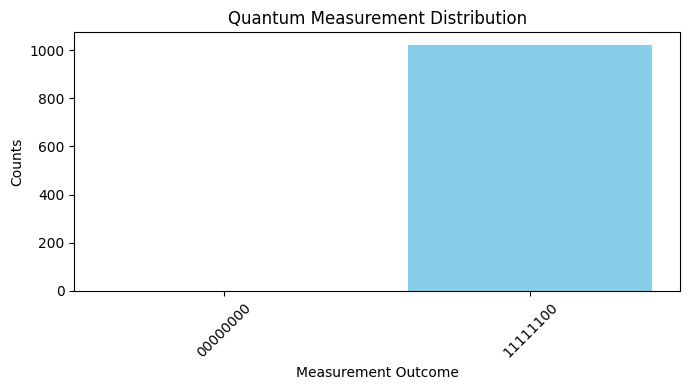

Connected to database quantummusic successfully.
Tables ensured.
Inserted analysis record with ID: 50
Database connection closed.

Now playing the processed audio (bandpass, normalized, trimmed):


\nNow playing the processed audio with percussion removed:


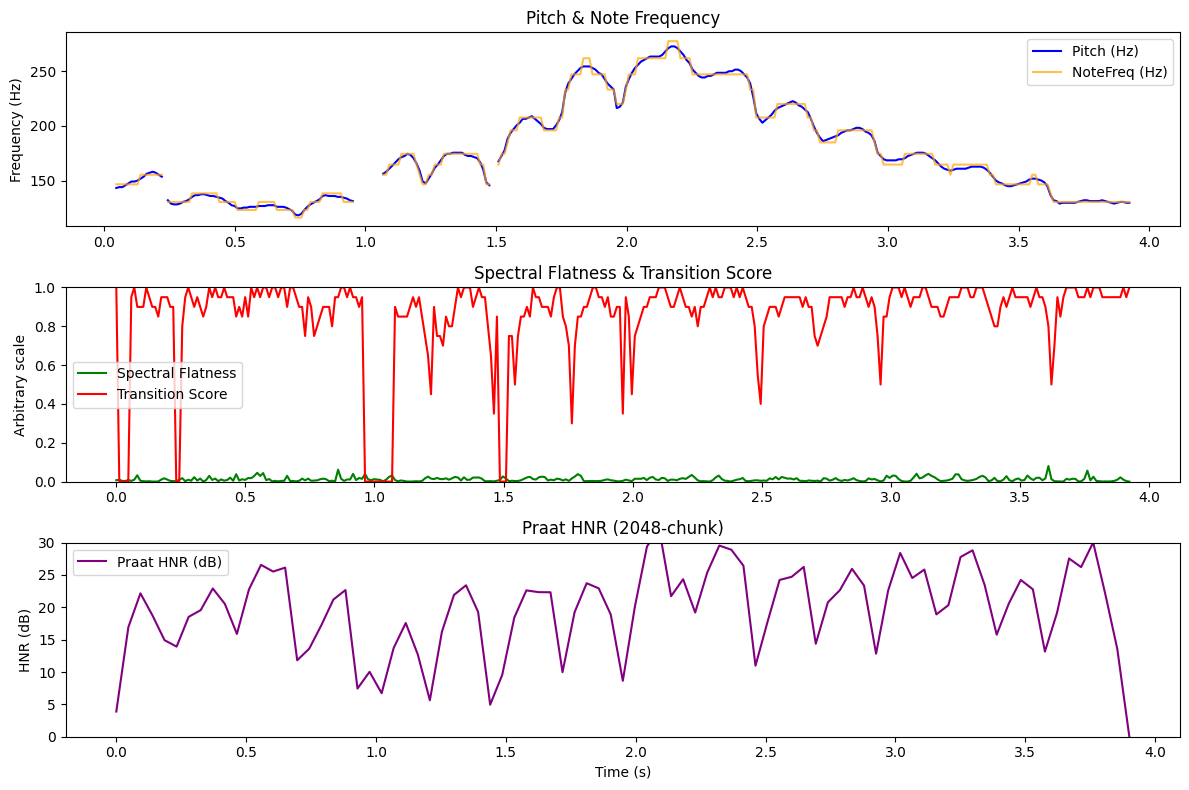

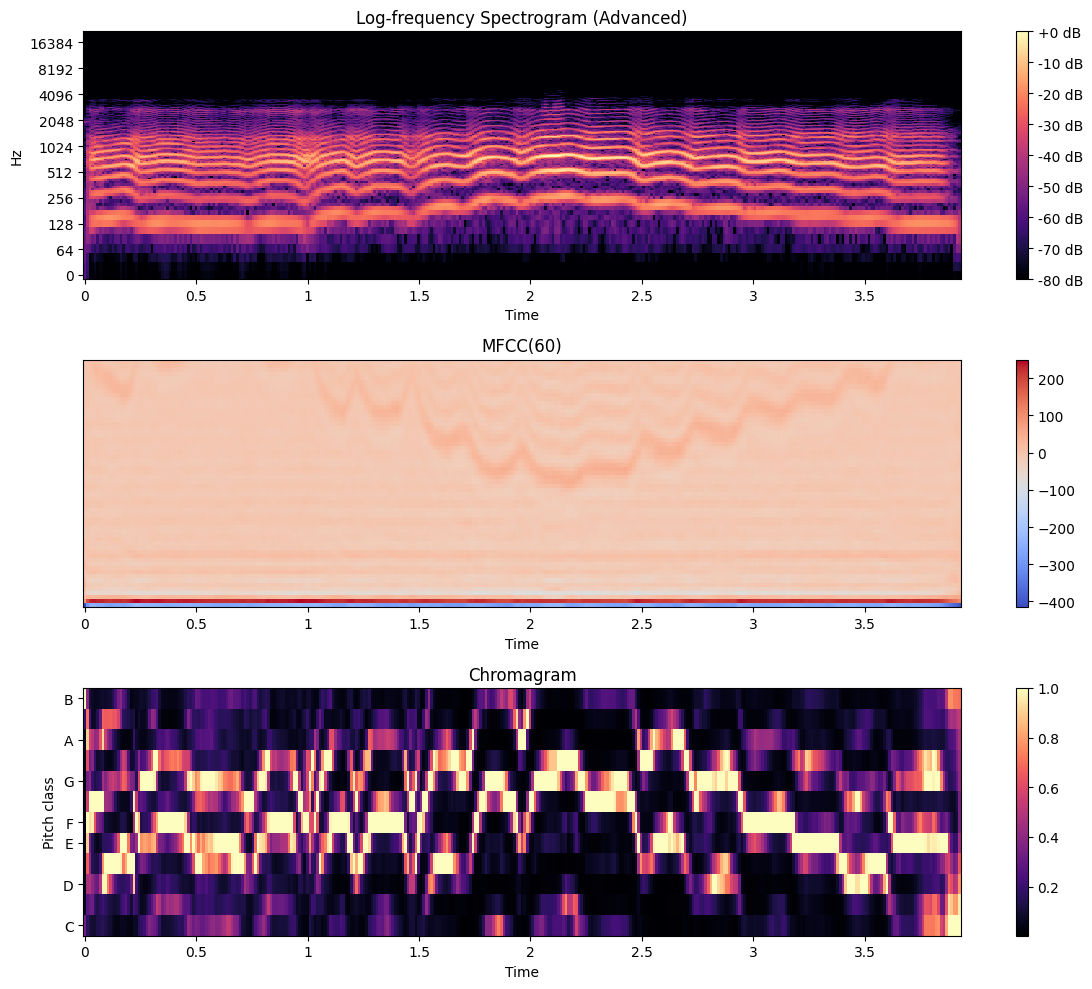

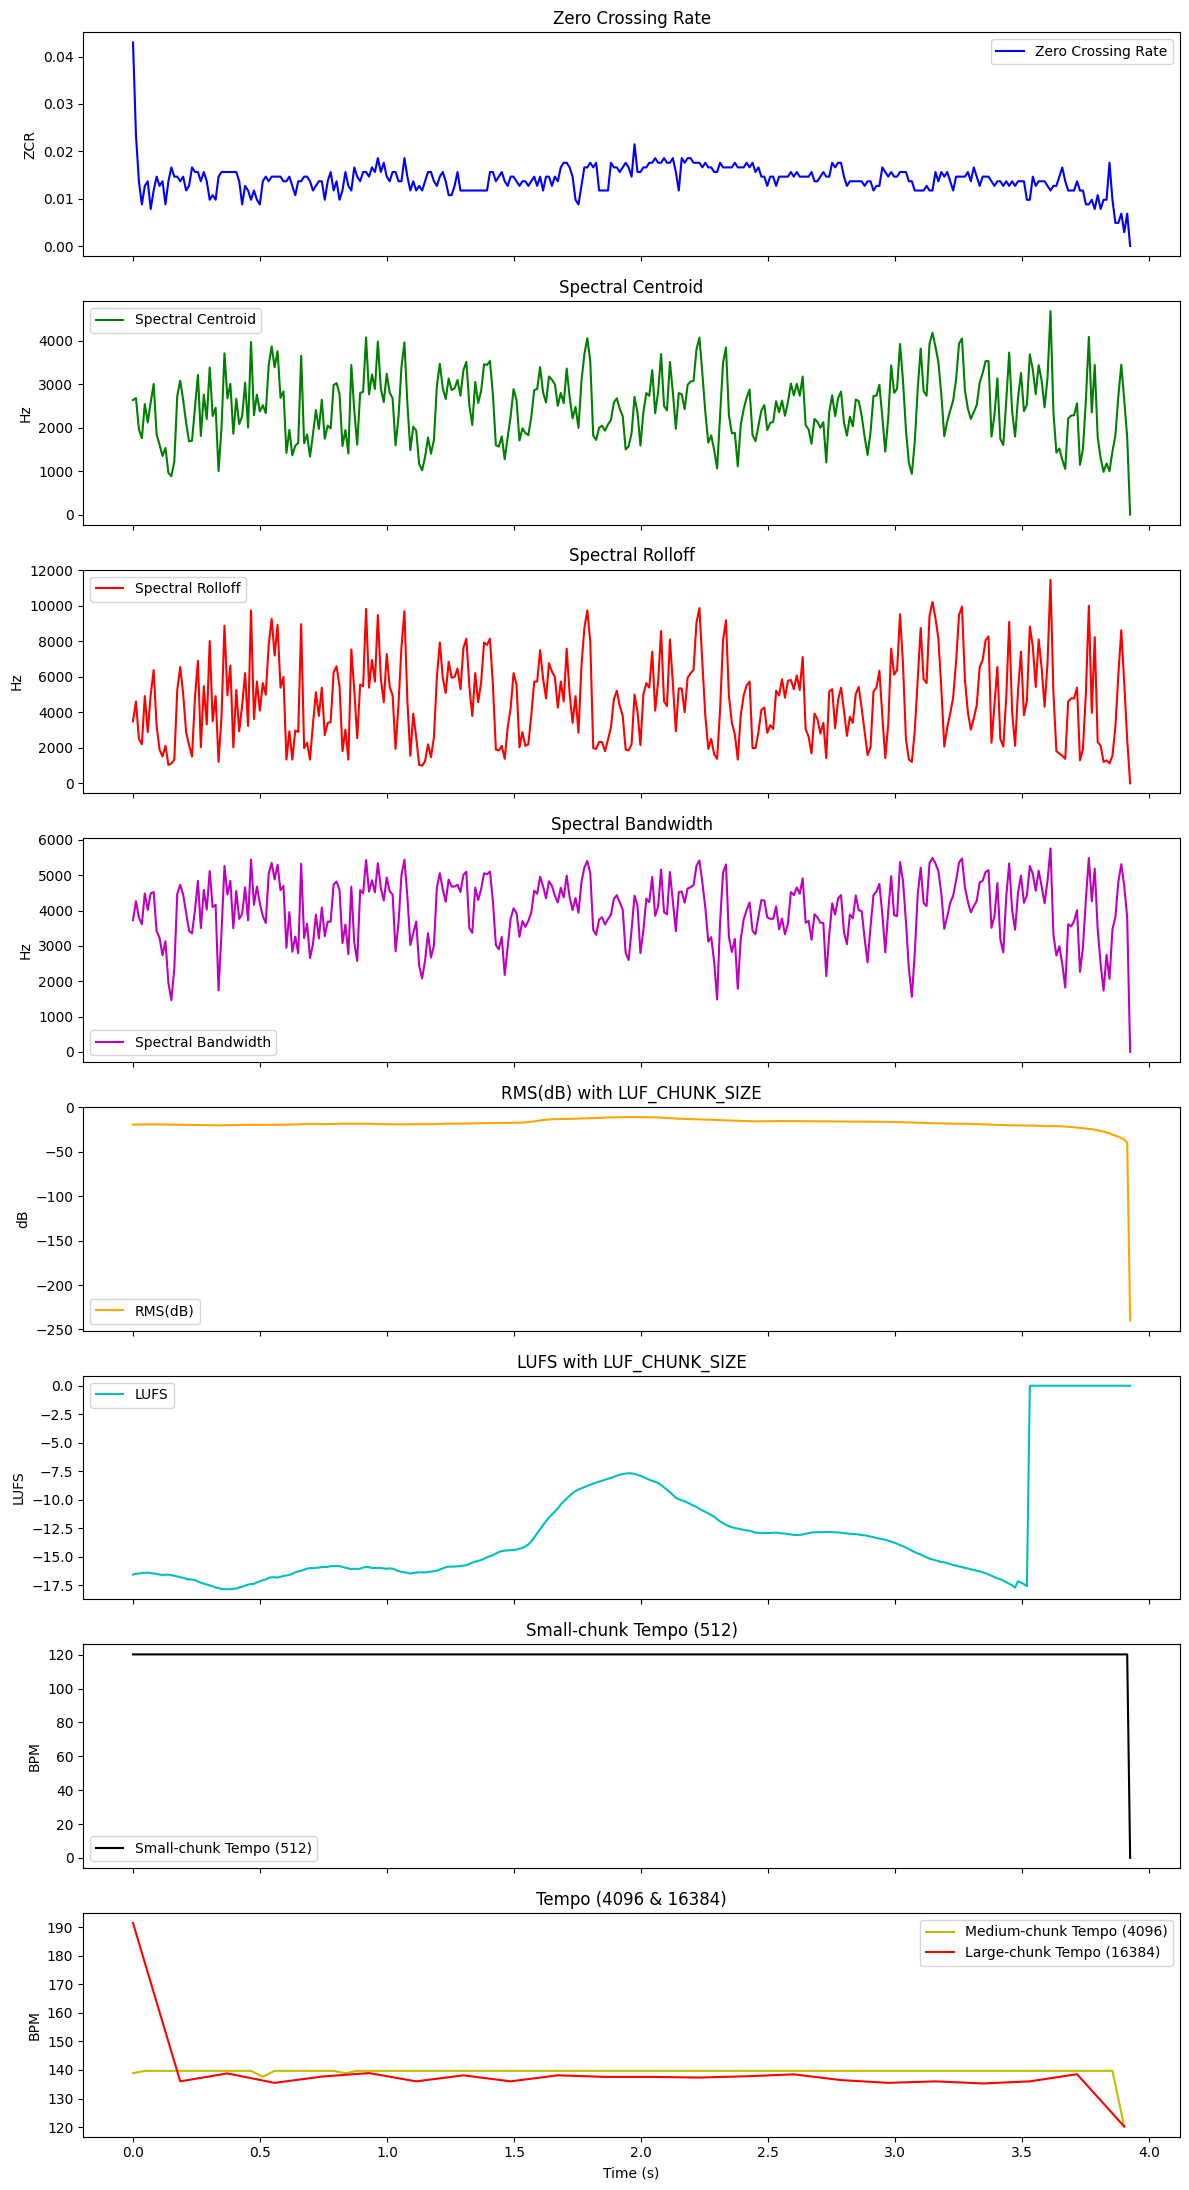

CHUNK-LEVEL FEEDBACK
Time ~0.00s: tempo is fast.
Time ~0.01s: tempo is fast.
Time ~0.01s: pitch transition was abrupt.
Time ~0.02s: tempo is fast.
Time ~0.02s: pitch transition was abrupt.
Time ~0.03s: tempo is fast.
Time ~0.03s: pitch transition was abrupt.
Time ~0.05s: tempo is fast.
Time ~0.05s: pitch transition was abrupt.
Time ~0.06s: tempo is fast.
Time ~0.07s: tempo is fast.
Time ~0.08s: tempo is fast.
Time ~0.09s: tempo is fast.
Time ~0.10s: tempo is fast.
Time ~0.12s: tempo is fast.
Time ~0.13s: tempo is fast.
Time ~0.14s: tempo is fast.
Time ~0.15s: tempo is fast.
Time ~0.16s: tempo is fast.
Time ~0.17s: tempo is fast.
Time ~0.19s: tempo is fast.
Time ~0.20s: tempo is fast.
Time ~0.21s: tempo is fast.
Time ~0.22s: tempo is fast.
Time ~0.23s: tempo is fast.
Time ~0.23s: pitch transition was abrupt.
Time ~0.24s: tempo is fast.
Time ~0.24s: pitch transition was abrupt.
Time ~0.26s: tempo is fast.
Time ~0.27s: tempo is fast.
Time ~0.28s: tempo is fast.
Time ~0.29s: tempo is fast.

In [57]:
result = grade_single_file("rohan3.wav")
# result  # Uncomment to see full analysis dictionary